# Vinyl Foam Mastercurve (auto TTS)

Use vinyl foam DMA sweeps across temperature to auto-build a mastercurve and fit models.

**Data:** examples/data/pyRheo/vinyl_foam/foam_dma_*C.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.models.herschel_bulkley import HerschelBulkley
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)
import arviz as az


INFO:2025-12-06 20:05:37,726:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load multi-temperature sweeps

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyRheo' / 'vinyl_foam'
files = sorted(DATA_DIR.glob('foam_dma_*C.csv'))

datasets = []
for fpath in files:
    temp_str = fpath.stem.split('_')[-1].replace('C','')
    temp_c = float(temp_str.replace('--','-') or 0)
    df = pd.read_csv(fpath, sep='	')
    df.columns = df.columns.str.strip()
    omega = df['Angular Frequency'].to_numpy()  # rad/s
    Gp = df['Storage Modulus'].to_numpy()
    Gpp = df['Loss Modulus'].to_numpy()
    datasets.append(RheoData(x=omega, y=Gp + 1j*Gpp, x_units='rad/s', y_units='Pa', domain='oscillation', metadata={'temperature': temp_c + 273.15}))

mc = Mastercurve(reference_temp=298.15, method='wlf', auto_shift=True)
master, shifts = mc.create_mastercurve(datasets, return_shifts=True)
print(f"Temps (C): {[round(d.metadata['temperature']-273.15,1) for d in datasets]}")


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 3.141045s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1137 | final_cost=2.847635e-05 | time=3.141s | final_gradient_norm=1.9593678066536493


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 3.070509s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1546 | final_cost=7.318832e-06 | time=3.071s | final_gradient_norm=4.681133328683614


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.236334s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1107 | final_cost=9.143014e-05 | time=2.236s | final_gradient_norm=4.942920114650096


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.541179s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1284 | final_cost=3.478873e-05 | time=2.541s | final_gradient_norm=5.504286342945557


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.279061s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1141 | final_cost=7.394126e-05 | time=2.279s | final_gradient_norm=10.056073311473455


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.694296s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1340 | final_cost=3.532695e-05 | time=2.694s | final_gradient_norm=6.769760690268101


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.082736s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1057 | final_cost=1.826033e-04 | time=2.083s | final_gradient_norm=14.131309467743717


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.540666s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1353 | final_cost=9.668900e-05 | time=2.541s | final_gradient_norm=3.1775047678020822


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.342685s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1180 | final_cost=2.290538e-04 | time=2.343s | final_gradient_norm=13.379307727787848


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.862893s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1422 | final_cost=9.390506e-05 | time=2.863s | final_gradient_norm=1.1678278408194886


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.300530s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1224 | final_cost=2.732868e-04 | time=2.301s | final_gradient_norm=9.249384848789871


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.770855s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1498 | final_cost=1.121638e-04 | time=2.771s | final_gradient_norm=4.923118158747282


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.979919s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1507 | final_cost=3.291866e-04 | time=2.980s | final_gradient_norm=0.10395682878995915


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 3.338261s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1756 | final_cost=1.515900e-04 | time=3.338s | final_gradient_norm=0.9973448360220061


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 4.147377s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=2334 | final_cost=5.237152e-05 | time=4.147s | final_gradient_norm=1.811542610485294


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 5.430815s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=2828 | final_cost=1.537233e-05 | time=5.431s | final_gradient_norm=0.04596603100312843


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.173190s


Convergence: reason=`gtol` termination condition is satisfied. | iterations=10 | final_cost=6.020703e-06 | time=0.173s | final_gradient_norm=4.296248934577283e-07


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.186308s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=14 | final_cost=6.006202e-06 | time=0.186s | final_gradient_norm=0.3318624878452313


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.180572s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=12 | final_cost=5.484181e-06 | time=0.181s | final_gradient_norm=6.2835244692127e-05


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.212510s


Convergence: reason=`gtol` termination condition is satisfied. | iterations=27 | final_cost=4.776305e-06 | time=0.213s | final_gradient_norm=2.2890066320307968e-07


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.183521s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=14 | final_cost=1.378606e-05 | time=0.184s | final_gradient_norm=0.0020447958774599947


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.232391s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=35 | final_cost=6.040234e-06 | time=0.232s | final_gradient_norm=1.5794995436200478e-06


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.177118s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=2.104074e-05 | time=0.177s | final_gradient_norm=0.011968817985013905


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.186681s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=15 | final_cost=6.741094e-06 | time=0.187s | final_gradient_norm=2.357875827101456e-06


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.175171s


Convergence: reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=10 | final_cost=1.984566e-06 | time=0.175s | final_gradient_norm=3.589858867217507e-06


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.169652s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=10 | final_cost=1.866241e-06 | time=0.170s | final_gradient_norm=2.1122693962855353e-06


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.131927s


Convergence: reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=9 | final_cost=4.920777e-05 | time=0.132s | final_gradient_norm=4.4753090025047414e-06


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.181508s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=3.252937e-05 | time=0.182s | final_gradient_norm=0.0001383206606126514


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.142279s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=5.539998e-05 | time=0.142s | final_gradient_norm=0.00035744967928987345


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.133452s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=1.461781e-05 | time=0.133s | final_gradient_norm=0.00011525856058986563


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.191403s


Convergence: reason=`gtol` termination condition is satisfied. | iterations=15 | final_cost=1.854740e-05 | time=0.191s | final_gradient_norm=4.141788472671135e-07


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.199102s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=18 | final_cost=1.844149e-05 | time=0.199s | final_gradient_norm=0.0023764463792100322


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.199455s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=1.260871e-04 | time=0.199s | final_gradient_norm=4.115960352902374


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.209188s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=26 | final_cost=2.781481e-05 | time=0.209s | final_gradient_norm=0.06322913347243793


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.208012s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=24 | final_cost=2.234716e-04 | time=0.208s | final_gradient_norm=0.6339786502414594


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.208783s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=25 | final_cost=3.796443e-05 | time=0.209s | final_gradient_norm=5.7969977989433135


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.211274s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=27 | final_cost=5.400780e-04 | time=0.211s | final_gradient_norm=34.7794298901261


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.219784s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=33 | final_cost=3.383210e-05 | time=0.220s | final_gradient_norm=0.04343451130040529


Temps (C): [-10.0, -15.0, -20.0, -25.0, -30.0, -35.0, -5.0, 0.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 5.0, 60.0]


## Plot raw vs shifted

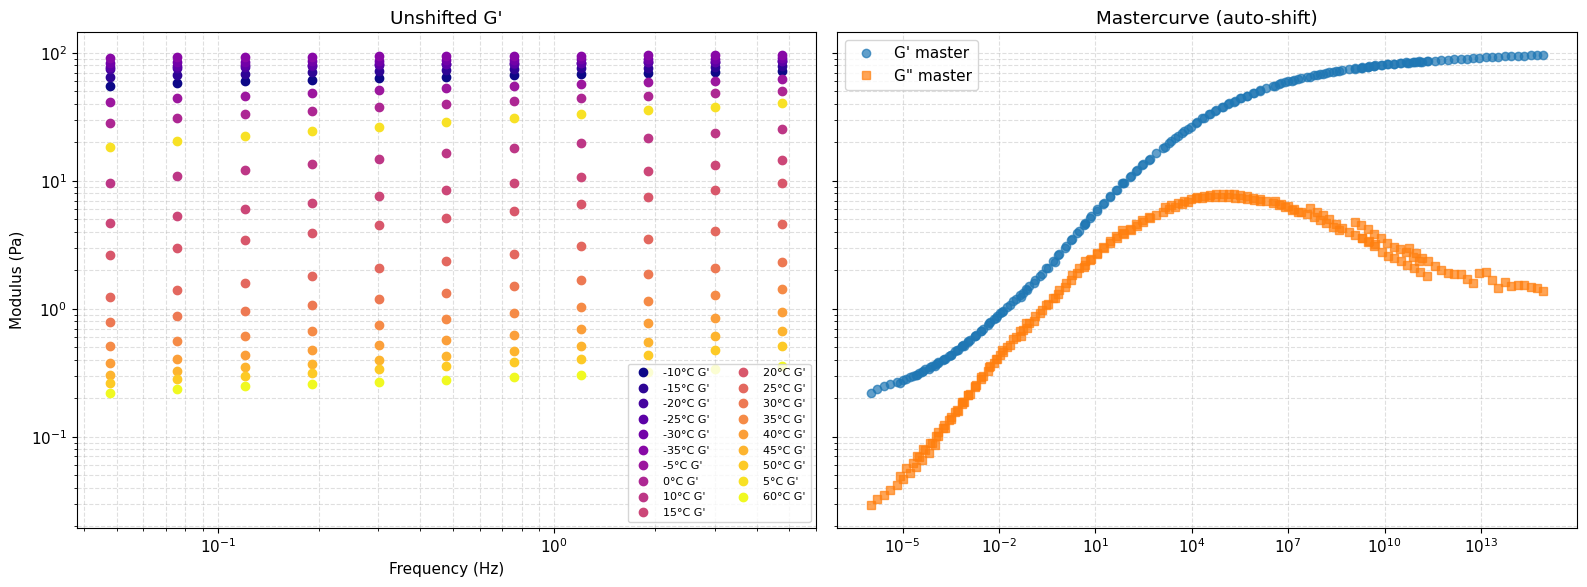

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
colors = plt.cm.plasma(np.linspace(0, 1, len(datasets)))
for c, data in zip(colors, datasets):
    temp_c = data.metadata['temperature'] - 273.15
    axes[0].loglog(data.x/(2*np.pi), np.real(data.y), 'o', color=c, label=f"{temp_c:.0f}°C G'")
axes[0].set_title("Unshifted G'")
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Modulus (Pa)')
axes[0].grid(True, which='both', ls='--', alpha=0.4)
axes[0].legend(ncol=2, fontsize=8)

axes[1].loglog(master.x/(2*np.pi), np.real(master.y), 'o', label="G' master", alpha=0.7)
axes[1].loglog(master.x/(2*np.pi), np.imag(master.y), 's', label='G" master', alpha=0.7)
axes[1].set_title('Mastercurve (auto-shift)')
axes[1].grid(True, which='both', ls='--', alpha=0.4)
axes[1].legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Fit models on mastercurve

In [5]:
omega_master = master.x
G_master = master.y

gm = GeneralizedMaxwell(n_modes=5, modulus_type='tensile')
gm.fit(omega_master, G_master, test_mode='oscillation', use_log_residuals=True)
gm_pred_components = gm.predict(omega_master)
gm_pred = gm_pred_components[:,0] + 1j*gm_pred_components[:,1]
gm_r2 = r2_complex(G_master, gm_pred)

fm_pred = np.full_like(G_master, np.nan)
fm_r2 = np.nan
try:
    fm = FractionalMaxwellModel()
    fm.fit(omega_master, G_master, test_mode='oscillation', use_log_residuals=True)
    fm_pred = fm.predict(omega_master, test_mode='oscillation')
    fm_r2 = r2_complex(G_master, fm_pred)
except Exception as exc:
    print(f"Fractional Maxwell fit failed: {exc}")

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})

Auto-enabling multi-start optimization for very wide range (20.9 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.886761s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=37 | final_cost=9.251854e+03 | time=0.887s | final_gradient_norm=6.055302737246656


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.311374s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=37 | final_cost=9.251854e+03 | time=0.311s | final_gradient_norm=6.055302737246656


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.868219s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=9.275799e+03 | time=0.868s | final_gradient_norm=1456778076.7605355


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.858595s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=18 | final_cost=9.379602e+03 | time=0.859s | final_gradient_norm=4758339426.218957


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.819082s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=9.958490e+03 | time=0.819s | final_gradient_norm=6747478561.9496975


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.198935s


Convergence: reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=4 | final_cost=1.559144e+04 | time=0.199s | final_gradient_norm=0.049085348239427395


Element minimization: early termination at n_modes=1 (R²=0.913460 < threshold=0.922971)


Element minimization: reducing from 5 to 2 modes


Auto-enabling multi-start optimization for very wide range (20.9 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.033496s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=58 | final_cost=1.061725e+02 | time=1.033s | final_gradient_norm=21875857.55827278


{'gm_r2': 0.9235943069771968, 'fm_r2': -1.020437142213758}


## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.279040s


Convergence: reason=`gtol` termination condition is satisfied. | iterations=17 | final_cost=4.246888e-04 | time=0.279s | final_gradient_norm=6.19139746135334e-07


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.222499s


Convergence: reason=`gtol` termination condition is satisfied. | iterations=17 | final_cost=4.246888e-04 | time=0.222s | final_gradient_norm=6.19139746135334e-07


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.183847s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=14 | final_cost=3.884822e-03 | time=0.184s | final_gradient_norm=35.25062842256163


Element minimization: early termination at n_modes=1 (R²=0.975800 < threshold=0.996032)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.281489s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=1.688533e-01 | time=0.281s | final_gradient_norm=0.0011992692847039312


Model ranking (R²): [('gm', 0.962), ('fm', -9.293)]


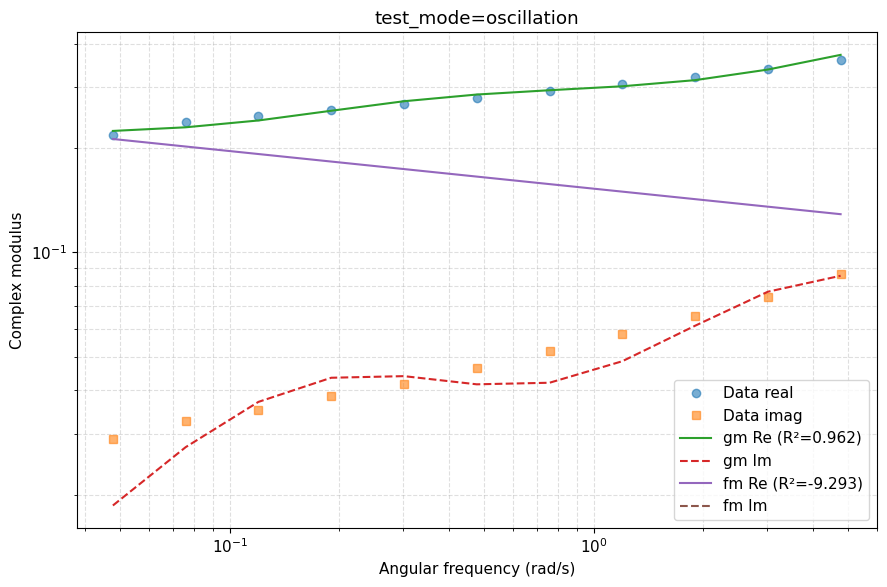

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<46:09,  1.44it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   3%|▎         | 138/4000 [00:00<00:16, 235.37it/s, 63 steps of size 2.29e-01. acc. prob=0.78]

warmup:   7%|▋         | 299/4000 [00:00<00:07, 505.03it/s, 31 steps of size 1.96e-01. acc. prob=0.78]

warmup:  13%|█▎        | 510/4000 [00:00<00:04, 856.31it/s, 31 steps of size 2.29e-01. acc. prob=0.79]

warmup:  19%|█▉        | 756/4000 [00:01<00:02, 1237.78it/s, 7 steps of size 4.50e-01. acc. prob=0.79]

warmup:  25%|██▍       | 991/4000 [00:01<00:01, 1518.90it/s, 63 steps of size 7.96e-02. acc. prob=0.79]

sample:  31%|███       | 1221/4000 [00:01<00:01, 1724.76it/s, 31 steps of size 2.01e-01. acc. prob=0.94]

sample:  36%|███▌      | 1446/4000 [00:01<00:01, 1868.43it/s, 15 steps of size 2.01e-01. acc. prob=0.94]

sample:  42%|████▏     | 1674/4000 [00:01<00:01, 1982.92it/s, 15 steps of size 2.01e-01. acc. prob=0.92]

sample:  48%|████▊     | 1907/4000 [00:01<00:01, 2080.71it/s, 15 steps of size 2.01e-01. acc. prob=0.92]

sample:  53%|█████▎    | 2135/4000 [00:01<00:00, 2136.50it/s, 31 steps of size 2.01e-01. acc. prob=0.92]

sample:  59%|█████▉    | 2364/4000 [00:01<00:00, 2179.86it/s, 15 steps of size 2.01e-01. acc. prob=0.92]

sample:  65%|██████▍   | 2590/4000 [00:01<00:00, 2200.84it/s, 15 steps of size 2.01e-01. acc. prob=0.92]

sample:  71%|███████   | 2828/4000 [00:01<00:00, 2253.68it/s, 31 steps of size 2.01e-01. acc. prob=0.91]

sample:  76%|███████▋  | 3058/4000 [00:02<00:00, 2255.96it/s, 15 steps of size 2.01e-01. acc. prob=0.91]

sample:  82%|████████▏ | 3287/4000 [00:02<00:00, 2257.64it/s, 31 steps of size 2.01e-01. acc. prob=0.91]

sample:  88%|████████▊ | 3526/4000 [00:02<00:00, 2295.52it/s, 15 steps of size 2.01e-01. acc. prob=0.91]

sample:  94%|█████████▍| 3758/4000 [00:02<00:00, 2301.44it/s, 15 steps of size 2.01e-01. acc. prob=0.91]

sample: 100%|█████████▉| 3991/4000 [00:02<00:00, 2307.97it/s, 15 steps of size 2.01e-01. acc. prob=0.91]

sample: 100%|██████████| 4000/4000 [00:02<00:00, 1597.71it/s, 15 steps of size 2.01e-01. acc. prob=0.91]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   4%|▎         | 141/4000 [00:00<00:02, 1407.50it/s, 11 steps of size 2.21e-01. acc. prob=0.78]

warmup:   9%|▉         | 357/4000 [00:00<00:01, 1848.10it/s, 7 steps of size 1.95e-01. acc. prob=0.78] 

warmup:  14%|█▍        | 571/4000 [00:00<00:01, 1979.47it/s, 15 steps of size 2.57e-01. acc. prob=0.79]

warmup:  20%|██        | 802/4000 [00:00<00:01, 2109.26it/s, 15 steps of size 2.17e-01. acc. prob=0.79]

sample:  26%|██▌       | 1024/4000 [00:00<00:01, 2148.89it/s, 15 steps of size 2.30e-01. acc. prob=0.85]

sample:  32%|███▏      | 1263/4000 [00:00<00:01, 2230.77it/s, 15 steps of size 2.30e-01. acc. prob=0.90]

sample:  38%|███▊      | 1500/4000 [00:00<00:01, 2274.80it/s, 15 steps of size 2.30e-01. acc. prob=0.90]

sample:  43%|████▎     | 1737/4000 [00:00<00:00, 2305.03it/s, 15 steps of size 2.30e-01. acc. prob=0.90]

sample:  50%|████▉     | 1985/4000 [00:00<00:00, 2358.27it/s, 15 steps of size 2.30e-01. acc. prob=0.90]

sample:  56%|█████▌    | 2225/4000 [00:01<00:00, 2370.31it/s, 15 steps of size 2.30e-01. acc. prob=0.90]

sample:  62%|██████▏   | 2464/4000 [00:01<00:00, 2374.26it/s, 15 steps of size 2.30e-01. acc. prob=0.90]

sample:  68%|██████▊   | 2703/4000 [00:01<00:00, 2378.83it/s, 15 steps of size 2.30e-01. acc. prob=0.91]

sample:  74%|███████▎  | 2948/4000 [00:01<00:00, 2399.69it/s, 15 steps of size 2.30e-01. acc. prob=0.91]

sample:  80%|███████▉  | 3188/4000 [00:01<00:00, 2393.27it/s, 15 steps of size 2.30e-01. acc. prob=0.91]

sample:  86%|████████▌ | 3428/4000 [00:01<00:00, 2381.21it/s, 15 steps of size 2.30e-01. acc. prob=0.91]

sample:  92%|█████████▏| 3675/4000 [00:01<00:00, 2405.98it/s, 15 steps of size 2.30e-01. acc. prob=0.91]

sample:  98%|█████████▊| 3917/4000 [00:01<00:00, 2409.17it/s, 7 steps of size 2.30e-01. acc. prob=0.91] 

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2299.25it/s, 15 steps of size 2.30e-01. acc. prob=0.91]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   4%|▍         | 167/4000 [00:00<00:02, 1668.67it/s, 31 steps of size 2.89e-01. acc. prob=0.78]

warmup:  10%|█         | 404/4000 [00:00<00:01, 2080.11it/s, 3 steps of size 3.49e-01. acc. prob=0.79] 

warmup:  16%|█▌        | 636/4000 [00:00<00:01, 2188.97it/s, 3 steps of size 3.97e-01. acc. prob=0.79]

warmup:  22%|██▏       | 896/4000 [00:00<00:01, 2349.26it/s, 15 steps of size 3.19e-01. acc. prob=0.79]

sample:  29%|██▊       | 1142/4000 [00:00<00:01, 2386.20it/s, 15 steps of size 2.24e-01. acc. prob=0.91]

sample:  35%|███▍      | 1381/4000 [00:00<00:01, 2020.39it/s, 15 steps of size 2.24e-01. acc. prob=0.92]

sample:  40%|████      | 1619/4000 [00:00<00:01, 2124.57it/s, 15 steps of size 2.24e-01. acc. prob=0.91]

sample:  46%|████▋     | 1859/4000 [00:00<00:00, 2204.30it/s, 15 steps of size 2.24e-01. acc. prob=0.91]

sample:  52%|█████▏    | 2094/4000 [00:00<00:00, 2245.70it/s, 15 steps of size 2.24e-01. acc. prob=0.92]

sample:  58%|█████▊    | 2335/4000 [00:01<00:00, 2293.29it/s, 15 steps of size 2.24e-01. acc. prob=0.92]

sample:  65%|██████▍   | 2584/4000 [00:01<00:00, 2350.30it/s, 15 steps of size 2.24e-01. acc. prob=0.91]

sample:  71%|███████   | 2829/4000 [00:01<00:00, 2377.97it/s, 15 steps of size 2.24e-01. acc. prob=0.91]

sample:  77%|███████▋  | 3069/4000 [00:01<00:00, 2376.69it/s, 23 steps of size 2.24e-01. acc. prob=0.91]

sample:  83%|████████▎ | 3308/4000 [00:01<00:00, 2367.74it/s, 7 steps of size 2.24e-01. acc. prob=0.91] 

sample:  89%|████████▊ | 3546/4000 [00:01<00:00, 2370.15it/s, 15 steps of size 2.24e-01. acc. prob=0.91]

sample:  95%|█████████▍| 3787/4000 [00:01<00:00, 2379.02it/s, 15 steps of size 2.24e-01. acc. prob=0.91]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2288.28it/s, 15 steps of size 2.24e-01. acc. prob=0.91]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   3%|▎         | 114/4000 [00:00<00:03, 1138.89it/s, 127 steps of size 9.01e-02. acc. prob=0.77]

warmup:   6%|▌         | 234/4000 [00:00<00:03, 1169.95it/s, 63 steps of size 5.80e-02. acc. prob=0.78] 

warmup:  11%|█▏        | 458/4000 [00:00<00:02, 1655.61it/s, 15 steps of size 5.51e-01. acc. prob=0.79]

warmup:  17%|█▋        | 668/4000 [00:00<00:01, 1830.07it/s, 7 steps of size 1.82e-01. acc. prob=0.79] 

warmup:  23%|██▎       | 902/4000 [00:00<00:01, 2012.08it/s, 15 steps of size 2.20e-01. acc. prob=0.79]

sample:  28%|██▊       | 1104/4000 [00:00<00:01, 2013.97it/s, 15 steps of size 1.89e-01. acc. prob=0.95]

sample:  33%|███▎      | 1312/4000 [00:00<00:01, 2034.15it/s, 15 steps of size 1.89e-01. acc. prob=0.95]

sample:  38%|███▊      | 1523/4000 [00:00<00:01, 2054.61it/s, 31 steps of size 1.89e-01. acc. prob=0.94]

sample:  43%|████▎     | 1731/4000 [00:00<00:01, 2061.10it/s, 15 steps of size 1.89e-01. acc. prob=0.94]

sample:  48%|████▊     | 1938/4000 [00:01<00:00, 2062.03it/s, 15 steps of size 1.89e-01. acc. prob=0.94]

sample:  54%|█████▎    | 2148/4000 [00:01<00:00, 2071.50it/s, 31 steps of size 1.89e-01. acc. prob=0.94]

sample:  59%|█████▉    | 2366/4000 [00:01<00:00, 2102.12it/s, 31 steps of size 1.89e-01. acc. prob=0.94]

sample:  65%|██████▍   | 2582/4000 [00:01<00:00, 2118.53it/s, 15 steps of size 1.89e-01. acc. prob=0.94]

sample:  70%|██████▉   | 2799/4000 [00:01<00:00, 2133.94it/s, 15 steps of size 1.89e-01. acc. prob=0.94]

sample:  75%|███████▌  | 3013/4000 [00:01<00:00, 2131.03it/s, 31 steps of size 1.89e-01. acc. prob=0.94]

sample:  81%|████████  | 3227/4000 [00:01<00:00, 2127.72it/s, 31 steps of size 1.89e-01. acc. prob=0.94]

sample:  86%|████████▌ | 3440/4000 [00:01<00:00, 2086.59it/s, 31 steps of size 1.89e-01. acc. prob=0.94]

sample:  91%|█████████▏| 3651/4000 [00:01<00:00, 2092.61it/s, 15 steps of size 1.89e-01. acc. prob=0.94]

sample:  97%|█████████▋| 3863/4000 [00:01<00:00, 2097.74it/s, 47 steps of size 1.89e-01. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2021.45it/s, 15 steps of size 1.89e-01. acc. prob=0.94]

array([[<Axes: ylabel='E_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='tau_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_2'>, <Axes: xlabel='E_2'>,
        <Axes: xlabel='E_inf'>, <Axes: xlabel='sigma_imag'>,
        <Axes: xlabel='sigma_real'>, <Axes: xlabel='tau_1'>]],
      dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_2\n0'}>,
        <Axes: title={'center': 'E_2\n1'}>,
        <Axes: title={'center': 'E_2\n2'}>,
        <Axes: title={'center': 'E_2\n3'}>],
       [<Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>,
        <Axes: title={'center': 'E_inf\n2'}>,
        <Axes: title={'center': 'E_inf\n3'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_imag\n1'}>,
        <Axes: title={'center': 'sigma_imag\n2'}>,
        <Axes: title={'center': 'sigma_imag\n3'}>],
       [<Axes: title={'center': 'sigma_real\n0'}>,
        <Axes: title={'center': 'sigma_real\n1'}>,
        <Axes: title={'center': 'sigma_real\n2'}>,
        <Axes: title={'center': 'sigma_real\n3'}>],
       [<Axes: title={'center': 'tau_1\n0'}>,
     

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'tau_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >, <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'tau_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: >, <Axes: >]], dtype=object)

Auto-enabling multi-start optimization for very wide range (20.9 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.304658s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=43 | final_cost=9.958485e+03 | time=0.305s | final_gradient_norm=2.148907538490507


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.303580s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=43 | final_cost=9.958485e+03 | time=0.304s | final_gradient_norm=2.148907538490507


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.219150s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=4 | final_cost=1.559144e+04 | time=0.219s | final_gradient_norm=0.0500744771296501


Element minimization: early termination at n_modes=1 (R²=0.913460 < threshold=0.917088)


Auto-enabling multi-start optimization for very wide range (20.9 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.416963s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=58 | final_cost=1.061725e+02 | time=0.417s | final_gradient_norm=21875857.55827278


Model ranking (R²): [('gm', 0.924), ('fm', -1.02)]


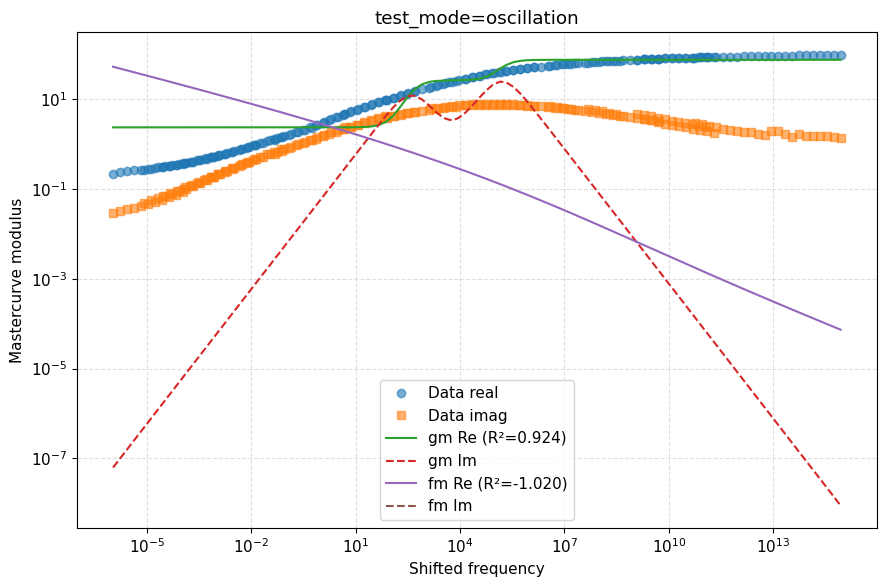

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<1:00:23,  1.10it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|▏         | 57/4000 [00:01<00:51, 77.13it/s, 511 steps of size 1.93e-02. acc. prob=0.75]

warmup:   4%|▍         | 175/4000 [00:01<00:14, 256.42it/s, 31 steps of size 1.66e-01. acc. prob=0.78]

warmup:   9%|▉         | 361/4000 [00:01<00:06, 558.70it/s, 15 steps of size 3.87e-01. acc. prob=0.78]

warmup:  15%|█▌        | 603/4000 [00:01<00:03, 952.92it/s, 31 steps of size 1.52e-01. acc. prob=0.79]

warmup:  22%|██▏       | 860/4000 [00:01<00:02, 1327.84it/s, 5 steps of size 3.61e-01. acc. prob=0.79]

sample:  28%|██▊       | 1104/4000 [00:01<00:01, 1604.21it/s, 15 steps of size 2.87e-01. acc. prob=0.93]

sample:  34%|███▎      | 1340/4000 [00:01<00:01, 1802.37it/s, 7 steps of size 2.87e-01. acc. prob=0.92] 

sample:  39%|███▉      | 1574/4000 [00:01<00:01, 1947.74it/s, 15 steps of size 2.87e-01. acc. prob=0.92]

sample:  45%|████▌     | 1808/4000 [00:01<00:01, 2057.17it/s, 15 steps of size 2.87e-01. acc. prob=0.91]

sample:  51%|█████     | 2045/4000 [00:01<00:00, 2143.53it/s, 15 steps of size 2.87e-01. acc. prob=0.91]

sample:  57%|█████▋    | 2280/4000 [00:02<00:00, 2201.67it/s, 15 steps of size 2.87e-01. acc. prob=0.92]

sample:  63%|██████▎   | 2512/4000 [00:02<00:00, 2235.95it/s, 3 steps of size 2.87e-01. acc. prob=0.91] 

sample:  69%|██████▊   | 2747/4000 [00:02<00:00, 2267.29it/s, 15 steps of size 2.87e-01. acc. prob=0.91]

sample:  75%|███████▍  | 2981/4000 [00:02<00:00, 2285.95it/s, 15 steps of size 2.87e-01. acc. prob=0.91]

sample:  80%|████████  | 3214/4000 [00:02<00:00, 2283.11it/s, 15 steps of size 2.87e-01. acc. prob=0.91]

sample:  86%|████████▋ | 3453/4000 [00:02<00:00, 2314.03it/s, 15 steps of size 2.87e-01. acc. prob=0.91]

sample:  92%|█████████▏| 3689/4000 [00:02<00:00, 2325.85it/s, 15 steps of size 2.87e-01. acc. prob=0.91]

sample:  98%|█████████▊| 3924/4000 [00:02<00:00, 2332.23it/s, 15 steps of size 2.87e-01. acc. prob=0.91]

sample: 100%|██████████| 4000/4000 [00:02<00:00, 1456.81it/s, 15 steps of size 2.87e-01. acc. prob=0.91]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   2%|▏         | 66/4000 [00:00<00:06, 643.14it/s, 191 steps of size 4.36e-02. acc. prob=0.76]

warmup:   5%|▍         | 188/4000 [00:00<00:03, 975.49it/s, 63 steps of size 8.90e-02. acc. prob=0.78]

warmup:  11%|█         | 426/4000 [00:00<00:02, 1608.79it/s, 15 steps of size 2.60e-01. acc. prob=0.79]

warmup:  17%|█▋        | 670/4000 [00:00<00:01, 1934.29it/s, 7 steps of size 4.12e-01. acc. prob=0.79] 

warmup:  23%|██▎       | 939/4000 [00:00<00:01, 2202.22it/s, 15 steps of size 4.34e-01. acc. prob=0.79]

sample:  29%|██▉       | 1160/4000 [00:00<00:01, 2188.89it/s, 15 steps of size 2.23e-01. acc. prob=0.92]

sample:  35%|███▍      | 1381/4000 [00:00<00:01, 2193.26it/s, 15 steps of size 2.23e-01. acc. prob=0.93]

sample:  40%|████      | 1606/4000 [00:00<00:01, 2210.23it/s, 15 steps of size 2.23e-01. acc. prob=0.93]

sample:  46%|████▌     | 1839/4000 [00:00<00:00, 2245.66it/s, 15 steps of size 2.23e-01. acc. prob=0.94]

sample:  52%|█████▏    | 2066/4000 [00:01<00:00, 2251.76it/s, 7 steps of size 2.23e-01. acc. prob=0.94] 

sample:  57%|█████▋    | 2292/4000 [00:01<00:00, 2249.03it/s, 15 steps of size 2.23e-01. acc. prob=0.94]

sample:  63%|██████▎   | 2517/4000 [00:01<00:00, 2229.60it/s, 15 steps of size 2.23e-01. acc. prob=0.94]

sample:  69%|██████▊   | 2741/4000 [00:01<00:00, 2221.33it/s, 15 steps of size 2.23e-01. acc. prob=0.94]

sample:  74%|███████▍  | 2964/4000 [00:01<00:00, 2213.14it/s, 15 steps of size 2.23e-01. acc. prob=0.94]

sample:  80%|███████▉  | 3188/4000 [00:01<00:00, 2218.03it/s, 31 steps of size 2.23e-01. acc. prob=0.94]

sample:  85%|████████▌ | 3410/4000 [00:01<00:00, 2207.77it/s, 15 steps of size 2.23e-01. acc. prob=0.94]

sample:  91%|█████████ | 3631/4000 [00:01<00:00, 2205.72it/s, 15 steps of size 2.23e-01. acc. prob=0.94]

sample:  96%|█████████▋| 3853/4000 [00:01<00:00, 2208.45it/s, 15 steps of size 2.23e-01. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2124.96it/s, 15 steps of size 2.23e-01. acc. prob=0.94]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   2%|▏         | 66/4000 [00:00<00:05, 659.64it/s, 127 steps of size 6.59e-02. acc. prob=0.76]

warmup:   5%|▍         | 199/4000 [00:00<00:03, 1051.66it/s, 47 steps of size 2.19e-01. acc. prob=0.78]

warmup:  11%|█         | 446/4000 [00:00<00:02, 1696.84it/s, 3 steps of size 7.83e-01. acc. prob=0.79] 

warmup:  18%|█▊        | 701/4000 [00:00<00:01, 2032.16it/s, 6 steps of size 2.59e-01. acc. prob=0.79]

warmup:  24%|██▍       | 973/4000 [00:00<00:01, 2278.75it/s, 15 steps of size 4.89e-01. acc. prob=0.79]

sample:  31%|███       | 1233/4000 [00:00<00:01, 2384.90it/s, 15 steps of size 3.65e-01. acc. prob=0.78]

sample:  37%|███▋      | 1488/4000 [00:00<00:01, 2435.54it/s, 15 steps of size 3.65e-01. acc. prob=0.78]

sample:  44%|████▍     | 1756/4000 [00:00<00:00, 2513.18it/s, 15 steps of size 3.65e-01. acc. prob=0.80]

sample:  50%|█████     | 2019/4000 [00:00<00:00, 2548.63it/s, 7 steps of size 3.65e-01. acc. prob=0.80] 

sample:  57%|█████▋    | 2278/4000 [00:01<00:00, 2560.40it/s, 7 steps of size 3.65e-01. acc. prob=0.80]

sample:  64%|██████▎   | 2541/4000 [00:01<00:00, 2578.47it/s, 15 steps of size 3.65e-01. acc. prob=0.80]

sample:  70%|███████   | 2807/4000 [00:01<00:00, 2601.55it/s, 15 steps of size 3.65e-01. acc. prob=0.80]

sample:  77%|███████▋  | 3068/4000 [00:01<00:00, 2588.33it/s, 15 steps of size 3.65e-01. acc. prob=0.81]

sample:  83%|████████▎ | 3327/4000 [00:01<00:00, 2577.74it/s, 7 steps of size 3.65e-01. acc. prob=0.80] 

sample:  90%|████████▉ | 3589/4000 [00:01<00:00, 2589.99it/s, 3 steps of size 3.65e-01. acc. prob=0.81]

sample:  96%|█████████▌| 3849/4000 [00:01<00:00, 2569.71it/s, 7 steps of size 3.65e-01. acc. prob=0.81]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2396.44it/s, 7 steps of size 3.65e-01. acc. prob=0.81]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|▏         | 51/4000 [00:00<00:07, 506.85it/s, 39 steps of size 4.34e-02. acc. prob=0.75]

warmup:   3%|▎         | 137/4000 [00:00<00:05, 712.03it/s, 31 steps of size 4.21e-01. acc. prob=0.78]

warmup:   8%|▊         | 325/4000 [00:00<00:02, 1241.56it/s, 15 steps of size 3.41e-01. acc. prob=0.78]

warmup:  14%|█▍        | 561/4000 [00:00<00:02, 1680.39it/s, 15 steps of size 3.38e-01. acc. prob=0.79]

warmup:  21%|██        | 824/4000 [00:00<00:01, 2021.81it/s, 7 steps of size 6.35e-01. acc. prob=0.79] 

sample:  27%|██▋       | 1065/4000 [00:00<00:01, 2153.47it/s, 7 steps of size 2.67e-01. acc. prob=0.95]

sample:  32%|███▏      | 1297/4000 [00:00<00:01, 2205.59it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample:  38%|███▊      | 1525/4000 [00:00<00:01, 2227.50it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample:  44%|████▍     | 1755/4000 [00:00<00:00, 2248.43it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample:  50%|████▉     | 1986/4000 [00:01<00:00, 2264.78it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample:  55%|█████▌    | 2216/4000 [00:01<00:00, 2274.04it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample:  61%|██████    | 2444/4000 [00:01<00:00, 2260.54it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample:  67%|██████▋   | 2674/4000 [00:01<00:00, 2272.23it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample:  73%|███████▎  | 2902/4000 [00:01<00:00, 2246.78it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample:  78%|███████▊  | 3131/4000 [00:01<00:00, 2257.43it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample:  84%|████████▍ | 3362/4000 [00:01<00:00, 2271.00it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample:  90%|████████▉ | 3590/4000 [00:01<00:00, 2271.97it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample:  95%|█████████▌| 3818/4000 [00:01<00:00, 2269.45it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2113.87it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

array([[<Axes: ylabel='E_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='tau_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_2'>, <Axes: xlabel='E_2'>,
        <Axes: xlabel='E_inf'>, <Axes: xlabel='sigma_imag'>,
        <Axes: xlabel='sigma_real'>, <Axes: xlabel='tau_1'>]],
      dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_2\n0'}>,
        <Axes: title={'center': 'E_2\n1'}>,
        <Axes: title={'center': 'E_2\n2'}>,
        <Axes: title={'center': 'E_2\n3'}>],
       [<Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>,
        <Axes: title={'center': 'E_inf\n2'}>,
        <Axes: title={'center': 'E_inf\n3'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_imag\n1'}>,
        <Axes: title={'center': 'sigma_imag\n2'}>,
        <Axes: title={'center': 'sigma_imag\n3'}>],
       [<Axes: title={'center': 'sigma_real\n0'}>,
        <Axes: title={'center': 'sigma_real\n1'}>,
        <Axes: title={'center': 'sigma_real\n2'}>,
        <Axes: title={'center': 'sigma_real\n3'}>],
       [<Axes: title={'center': 'tau_1\n0'}>,
     

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'tau_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >, <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'tau_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: >, <Axes: >]], dtype=object)

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics
import arviz as az

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
